In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.transforms import Grayscale, ToTensor
from convolutional_ar.model import ConvAR
from sklearn.decomposition import PCA

In [2]:
class ConvAR(nn.Module):
    def __init__(self, kernel, pad, dilation=1):
        super().__init__()
        self.kernel = nn.Parameter(kernel)
        self.pad = pad
        self.dilation = dilation
        self.kernel.register_hook(
           lambda grad: self.equalize_grad(grad)
        )

    def forward(self, X):
        return torch.conv2d(X, self.kernel, padding=self.pad, dilation=self.dilation)

    @staticmethod
    def equalize_grad(grad: torch.tensor):
        grad[:, :, grad.shape[2]//2, grad.shape[3]//2] = 0.
        return grad

def train(im, model, n_epochs=100, lr=1e-4, loss_fn=nn.MSELoss(), verbose=False):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for i in range(n_epochs):
        im_pred = model(im)
        loss = loss_fn(im_pred, im)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if verbose:
            print(float(loss), end="\r" if i < (n_epochs - 1) else None)
    return model

In [3]:
im = read_image("example.jpg")
im_norm = im / 255 # to range (0, 1)

im_np = im.permute(1, 2, 0).numpy()
im_reshape = im_norm[:, :320, :480] # trim for equal size grid

C, H, W = im.shape
grid_h, grid_w = 8, 8
tile_h, tile_w = H // grid_h, W // grid_w  # (64, 96)

# reshape
im_reshape = (
    im_reshape.reshape(C, grid_h, tile_h, grid_w, tile_w)
      .permute(1, 3, 0, 2, 4)
)

im_reshape = im_reshape.reshape(-1, C, tile_h, tile_w)

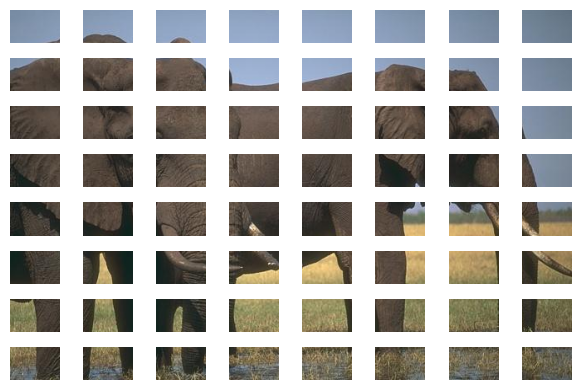

In [4]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(6, 4))
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(im_reshape[i].permute(1, 2, 0).numpy())
    axes[i].axis("off")
plt.tight_layout()

In [6]:
n_epochs = 500
lr = 1e-4

# Kernel params
r = 13 # length of kernel: (W, H)
dilation = 2 # scale of kernel
pad = dilation * (r - 1) // 2 # padding to ensure output is same shape as input
kernel = torch.zeros((3, 3, r, r)) # initial kernel

# Learn Kernels
kernels = torch.zeros((len(im_reshape), 3, 3, r, r))

im_tensor = im_reshape.to("mps")

loss_fn=nn.L1Loss()

for i, _im in enumerate(im_tensor):
    m = train(_im, ConvAR(kernel=kernel.clone(), pad=pad, dilation=dilation).to("mps"),
              n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)
    kernels[i] = m.kernel.detach()
kernels = kernels.reshape(len(kernels), -1).numpy()

In [7]:
# PCA
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(kernels)
kernels = pca.components_.reshape(n_components, 3, 3, r, r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8543443..1.0937229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0673292..1.0830309].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3661348..1.2215248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9781321..1.2462914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3262218..2.2265437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0311102..1.78069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6715817.

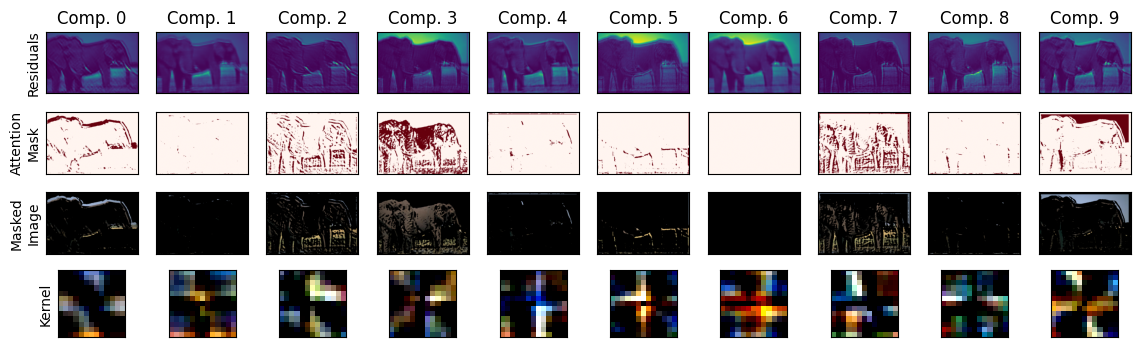

In [8]:
# MSE per kernel
errors = torch.zeros((n_components, 321, 481))
for i, k in enumerate(kernels):
    re = torch.conv2d(im_norm, torch.from_numpy(k), padding=pad, dilation=dilation)
    errors[i] = ((im_norm - re)**2).mean(0)

# Argmin of errors
amin = torch.argmin(errors, dim=0).numpy()

# Plot results
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(14, 4))
for i in range(n_components):

    ax = axes[0, i]
    ax.imshow(errors[i])
    if i == 0:
        ax.set_ylabel("Residuals")
    ax.set_title(f"Comp. {i}")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1, i]
    mask = amin == i
    ax.imshow(mask, cmap="Reds")
    if i == 0:
        ax.set_ylabel("Attention\nMask")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[2, i]
    _im = im_np.copy()
    _im[~mask] = 0
    ax.imshow(_im)
    if i == 0:
        ax.set_ylabel("Masked\nImage")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[3, i]
    if i == 0:
        ax.set_ylabel("Kernel")
    ax.imshow(
        torch.from_numpy(pca.components_[i].reshape(3, 3, r, r).mean(axis=1)).permute(1,2,0).numpy() * 20
    )
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
n_epochs = 200
lr = 1e-4
r = 9
dilation = 2
pad = dilation * (r - 1) // 2
kernel = torch.zeros((3, 3, r, r))

kernels = torch.zeros((len(im_reshape), 3, 3, r, r))

loss_fn=nn.L1Loss()
for i, _im in enumerate(im_tensor):
    m = train(_im, ConvAR(kernel=kernel.clone(), pad=pad, dilation=dilation).to("mps"), n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)
    kernels[i] = m.kernel.detach()
kernels= k.reshape(len(k), -1).numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# PCA
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(kernels)
kernels = pca.components_.reshape(n_components, 3, 3, r, r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2679191..1.5469639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.144481..2.6044598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4094733..2.1468349].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0123665..1.9343717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2412069..1.6944265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84163606..2.3075156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.011907

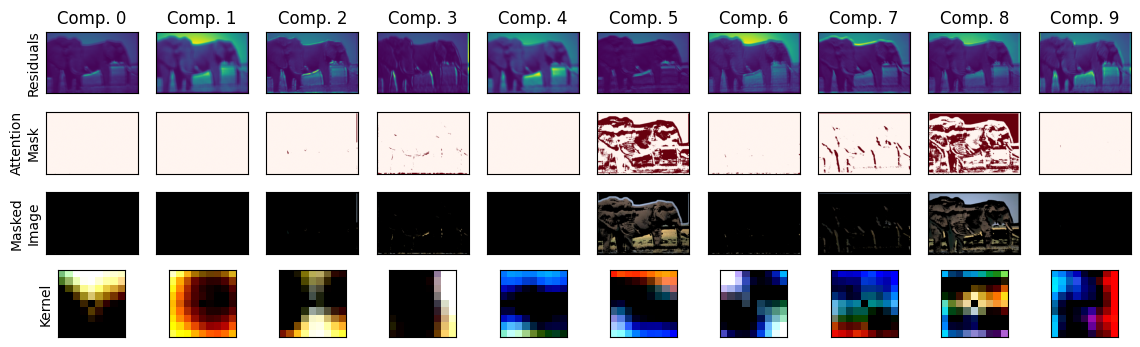

In [ ]:
errors = torch.zeros((n_components, 321, 481))
for i, k in enumerate(kernels):
    re = torch.conv2d(im_norm, torch.from_numpy(k), padding=pad, dilation=dilation)
    # errors[i] = torch.abs(im_norm - re).mean(0)
    errors[i] = ((im_norm - re)**2).mean(0)

amin = torch.argmin(errors, dim=0).numpy()

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(14, 4))
for i in range(n_components):

    ax = axes[0, i]
    ax.imshow(errors[i])
    if i == 0:
        ax.set_ylabel("Residuals")
    ax.set_title(f"Comp. {i}")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1, i]
    mask = amin == i
    ax.imshow(mask, cmap="Reds")
    if i == 0:
        ax.set_ylabel("Attention\nMask")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[2, i]
    _im = im_np.copy()
    _im[~mask] = 0
    ax.imshow(_im)
    if i == 0:
        ax.set_ylabel("Masked\nImage")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[3, i]
    if i == 0:
        ax.set_ylabel("Kernel")
    ax.imshow(
        torch.from_numpy(pca.components_[i].reshape(3, 3, r, r).mean(axis=1)).permute(1,2,0).numpy() * 20
    )
    ax.set_xticks([])
    ax.set_yticks([])